In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


Invitro Cell Research: 56 useable features with some meta data that I won't investigate until later in the process. 55 of these features are numeric with one being categorical. This means I will be using Kendalls correlation and mutual information for vetting. I will being with bringing the data in and taking a first look at balance seen in the dependent variable and see if any balancing needs to occur.

In [2]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import catboost as cb

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from numpy import where
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier as RF, VotingClassifier
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler
#from tabpfn import TabPFNClassifier
from xgboost import XGBClassifier as xgb, DMatrix

In [3]:
#import the data
Train = pd.read_csv(r'/kaggle/input/icr-identify-age-related-conditions/train.csv')
Test = pd.read_csv(r'/kaggle/input/icr-identify-age-related-conditions/test.csv')
Train['Class'].describe()

count    617.000000
mean       0.175041
std        0.380310
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Class, dtype: float64

In [4]:
Test.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It is a bit weighted towards the negative class. So I will transform the data to better fit and then enact SMOTE

In [5]:
#Make lists to section Train Dataset
Columns = Train.columns
numeric_features = list(Columns)
Columns = list(Columns)
Columns.remove('Id')
numeric_features.remove('Id')
numeric_features.remove('EJ')
numeric_features.remove('Class')
categorical_features = ['EJ']
target = ['Class']
features = numeric_features + categorical_features

print(len(numeric_features))

55


In [6]:
#Remove Null Value rows
Train = Train.dropna()
Train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,...,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,0.462860,3502.844518,118.817523,37.971167,10.196422,5.379830,0.062971,10.828981,8.718112,5382.822970,...,4.604619,3.746416,0.423671,20.552888,132.944954,15973.953703,31.364689,52.767917,9.448235,0.186131
std,0.395050,2281.427013,134.529098,68.540076,10.898788,2.506650,0.442135,4.408974,69.114063,3165.156480,...,9.095599,53.199582,1.376450,10.072061,151.520840,20083.928101,9.879365,37.285570,10.476576,0.389568
min,0.085460,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.874248,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.246766,2198.933605,85.200147,12.030297,8.138688,4.066281,0.025578,8.532908,1.229900,4161.104110,...,0.173229,0.552957,0.067730,14.020440,72.611063,3247.748035,25.033958,23.279172,0.150069,0.000000
50%,0.341840,3090.383560,85.200147,20.135146,8.138688,4.947752,0.025578,10.681890,1.229900,4992.779215,...,2.151784,1.157970,0.250601,18.650510,72.611063,8762.168480,30.519642,43.785085,0.594000,0.000000
75%,0.552285,4367.771182,107.739039,37.083478,8.138688,6.183582,0.037910,13.185360,5.390476,6020.698707,...,6.050474,1.506550,0.523214,25.064239,125.135266,21747.642820,36.822086,70.791728,21.978000,0.000000
max,4.435374,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


In [7]:
#Define Transformer
power = PowerTransformer(method='yeo-johnson', standardize=True)

#Transform numeric_features
for x in numeric_features:
    Train[x] = power.fit_transform(Train[[x]])
    Test[x] = power.fit_transform(Test[[x]])

Train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,-1.013232,-0.014836,-0.661201,0.121747,-0.514708,-3.853406,-0.590473,-0.160668,1.056015,...,1.015148,0.935196,-0.912535,-1.150300,-0.750400,-1.023629,-0.952704,0.668850,-0.986140,1
1,007255e47698,-1.599303,-1.518708,-0.661201,0.694949,-0.514708,-0.808579,-0.590473,0.654113,-0.853577,...,-1.063596,-1.395844,0.961811,-1.608284,-0.750400,0.968079,-0.130185,-0.385998,1.136380,0
2,013f2bd269f5,0.468559,-0.273655,-0.661201,0.552191,-0.514708,0.757001,-0.590473,0.508268,-0.853577,...,1.051898,-0.125146,1.705838,1.574804,0.129387,0.329879,-0.251437,-0.272937,-0.926287,0
3,043ac50845d5,-0.684969,0.331468,1.309237,1.371753,-0.514708,-0.773789,-0.590473,0.122582,-0.853577,...,0.895285,-1.395844,0.124149,-0.015149,-0.150241,-0.997528,0.913062,1.069413,-0.957831,0
4,044fb8a146ec,0.078292,0.291497,-0.661201,-0.497542,-0.514708,-0.610975,1.252210,-1.895186,1.957704,...,1.089035,3.186958,-0.726407,-0.296105,1.250025,-0.048342,1.366296,-0.235132,-1.005667,1


In [8]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

#encode categorical variables
for x in categorical_features:
    Train[x] = label_encoder.fit_transform(Train[x])
    Test[x] = label_encoder.fit_transform(Test[x])

Train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,5.480000e+02,5.480000e+02,5.480000e+02,5.480000e+02,5.480000e+02,5.480000e+02,5.480000e+02,5.480000e+02,5.480000e+02,5.480000e+02,...,5.480000e+02,5.480000e+02,5.480000e+02,5.480000e+02,5.480000e+02,5.480000e+02,5.480000e+02,5.480000e+02,5.480000e+02,548.000000
mean,-3.322565e-16,1.361441e-16,-4.396412e-09,4.991952e-16,6.801515e-09,-2.366315e-16,2.301484e-16,-3.889832e-17,6.320978e-17,1.770198e-14,...,4.862291e-17,-1.393857e-16,-1.871982e-16,3.338773e-16,-2.669621e-12,2.431145e-17,6.256147e-16,2.228550e-16,1.134534e-16,0.186131
std,1.000914e+00,1.000914e+00,1.000914e+00,1.000914e+00,1.000914e+00,1.000914e+00,1.000914e+00,1.000914e+00,1.000914e+00,1.000914e+00,...,1.000914e+00,1.000914e+00,1.000914e+00,1.000914e+00,1.000914e+00,1.000914e+00,1.000914e+00,1.000914e+00,1.000914e+00,0.389568
min,-2.274422e+00,-2.758884e+00,-6.612005e-01,-3.062853e+00,-5.147084e-01,-3.853406e+00,-5.904728e-01,-1.895186e+00,-8.535769e-01,-4.187343e+00,...,-1.063596e+00,-1.395844e+00,-1.115285e+00,-3.060297e+00,-7.504001e-01,-2.949938e+00,-3.057897e+00,-3.010256e+00,-1.089609e+00,0.000000
25%,-7.236652e-01,-5.383770e-01,-6.612005e-01,-7.314475e-01,-5.147084e-01,-5.353574e-01,-5.904728e-01,-4.656968e-01,-8.535769e-01,-5.543000e-01,...,-1.063596e+00,-1.206293e+00,-1.115285e+00,-6.599124e-01,-7.504001e-01,-7.264300e-01,-5.938489e-01,-7.653687e-01,-9.623558e-01,0.000000
50%,-1.212847e-01,-2.454681e-02,-6.612005e-01,-1.276202e-02,-5.147084e-01,-4.562712e-02,-5.904728e-01,3.895458e-02,-8.535769e-01,4.007207e-02,...,1.470380e-01,2.017693e-01,-2.219683e-02,-1.231238e-04,-7.504001e-01,-2.721100e-02,1.644492e-02,9.645797e-03,-6.750742e-01,0.000000
75%,7.530886e-01,5.724460e-01,9.416519e-01,6.981689e-01,-5.147084e-01,5.315251e-01,4.170064e-01,5.845092e-01,1.030792e+00,6.085609e-01,...,8.871420e-01,6.857742e-01,8.623292e-01,6.808391e-01,1.015715e+00,7.338485e-01,6.331643e-01,6.892476e-01,1.136380e+00,0.000000
max,2.376152e+00,5.692177e+00,1.982299e+00,2.535176e+00,2.188836e+00,5.762778e+00,2.342459e+00,4.927379e+00,2.012253e+00,4.911749e+00,...,2.438047e+00,3.269614e+00,2.281552e+00,4.429165e+00,1.867090e+00,2.780361e+00,3.691022e+00,2.379679e+00,1.136380e+00,1.000000


It only removed 3 cases so I will now add in SMOTE to try and even it out more

In [9]:
#Now to use SMOTE
oversampling = SMOTE()

X = Train[features]
y = Train[target]

X, y = oversampling.fit_resample(X, y)

#Make a new train data frame
X_frame = pd.DataFrame(X)
y_frame = pd.DataFrame(y)
Train = pd.concat([X_frame, y_frame], axis = 1)

Train['Class'].describe()


count    892.000000
mean       0.500000
std        0.500281
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: Class, dtype: float64

Now that the Data is prepped, it is time to begin feature selection!

In [10]:
#Finding Mutual information for Categorical variables

#Set up features and targets
X = Train[categorical_features]
y = Train[target]
y = y.values.ravel()

# Calculate mutual information
mi = mutual_info_classif(X, y)

combined_dict = {k: v for k, v in zip(categorical_features, mi)}

print(combined_dict)

{'EJ': 0.009142695395062628}


In [11]:
# Set up X and y for Kendall's correlation
X = Train[numeric_features]
y = Train[target]
y = y.values.ravel()

# Create a dataframe to store the correlation results
correlation_df = pd.DataFrame(columns=['Variable', 'Correlation', 'p-value'])

# Calculate Kendall's correlation coefficient for each independent variable
for var in numeric_features:
    correlation_coef, p_value = stats.kendalltau(X[var], y)
    correlation_df = pd.concat([correlation_df, pd.DataFrame({'Variable': [var],
                                                              'Correlation': [correlation_coef],
                                                              'p-value': [p_value]})], ignore_index=True)

# Sort the dataframe by p-value in descending order
correlation_df_sorted = correlation_df.sort_values(by='p-value', ascending=False)

# Display the sorted dataframe
correlation_df_sorted.head(15)

,Variable,Correlation,p-value
52,GH,0.000313,0.990875
19,CH,-0.007153,0.794322
50,GE,-0.013238,0.657009
9,BD,0.013046,0.633588
6,AY,-0.030303,0.323449
7,AZ,0.032529,0.235976
13,BR,0.034323,0.210609
40,EP,-0.039797,0.175869
22,CS,-0.037259,0.173459
37,EG,0.038499,0.159529


A large amount of variables failed the null hypothis or show any mutual information. They will be cut as a result

In [12]:
#Time to chop
remove_list = ['GB', 'EJ', 'FC', 'BR', 'AZ', 'CF', 'CH', 'AH', 'EU', 'EL', 'GH', 'BD', 'EP', 'EG']

# Remove axed variables from features
features = [x for x in features if x not in remove_list]

# Remove axed variables from columns
Columns = [x for x in Columns if x not in remove_list]

#Use lists to rid usesless variables from data frame
Train = Train[Columns]

In [13]:
Train.describe()

,AB,AF,AM,AR,AX,AY,BC,BD,BN,BP,...,FE,FI,FL,FR,FS,GE,GF,GI,GL,Class
count,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,...,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000
mean,0.247071,0.224307,0.140556,0.131855,0.093943,-0.076981,0.153923,0.040311,0.141822,0.067282,...,0.118224,-0.068767,0.212109,0.091761,0.069707,-0.071196,-0.139525,0.081828,-0.141137,0.500000
std,0.983104,1.013980,0.996218,1.044387,0.954388,0.905900,0.994388,0.983589,0.916652,0.981374,...,1.052939,0.980411,1.064501,1.073686,0.973546,0.920915,0.929575,0.932309,0.989465,0.500281
min,-2.274422,-2.758884,-3.062853,-0.514708,-3.853406,-0.590473,-0.853577,-4.187343,-2.538592,-3.510159,...,-3.408658,-2.610550,-1.063596,-1.395844,-1.115285,-0.750400,-2.949938,-3.010256,-1.089609,0.000000
25%,-0.479894,-0.322884,-0.584896,-0.514708,-0.445968,-0.590473,-0.853577,-0.519018,-0.412710,-0.445728,...,-0.597340,-0.601593,-1.063596,-1.014155,-1.003184,-0.750400,-0.822907,-0.580020,-1.012425,0.000000
50%,0.295439,0.188413,0.123298,-0.514708,0.061142,-0.590473,0.011996,0.074932,0.202327,0.091845,...,0.037299,-0.110620,0.579565,0.234991,0.064169,-0.750400,-0.132584,0.077754,-0.858468,0.500000
75%,0.998643,0.737040,0.831492,0.677281,0.600545,0.092723,1.104641,0.591921,0.744926,0.635492,...,0.825613,0.457831,1.168357,0.789326,0.910049,0.716885,0.418006,0.731982,1.136380,1.000000
max,2.376152,5.692177,2.535176,2.188836,5.762778,2.342459,2.012253,4.911749,2.441351,3.294137,...,2.977330,6.199510,2.438047,3.269614,2.281552,1.867090,2.780361,2.379679,1.136380,1.000000


In [14]:
Test.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
count,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Time to use a feature selection algorithim. I'm using RF and basing it on how RF decides to place feature importance.

In [15]:
#Defining inputs
X = Train[features]
y = Train[target]

# Convert y to a 1D array
y = y.values.ravel()

#Creating Estimator algo for feature importance
sel = SelectFromModel(RF(n_estimators = 100))
sel.fit(X, y)

#Getting names of selected features
selected_feat = X.columns[(sel.get_support())]

# Displaying feature importance for each variable
print(selected_feat)

Index(['AB', 'AF', 'BC', 'BQ', 'CD ', 'CR', 'DA', 'DI', 'DL', 'DU', 'EE', 'FL',
       'GL'],
      dtype='object')


Using a recursive feature selection algorithim with a simple logistic regression to decide on the number of features the KBest algo should pick from the list given above.

In [16]:
X = Train[selected_feat]
y = Train[target]
y = y.values.ravel()

min_features_to_select = 1  # Minimum number of features to consider
clf = LR()
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 12


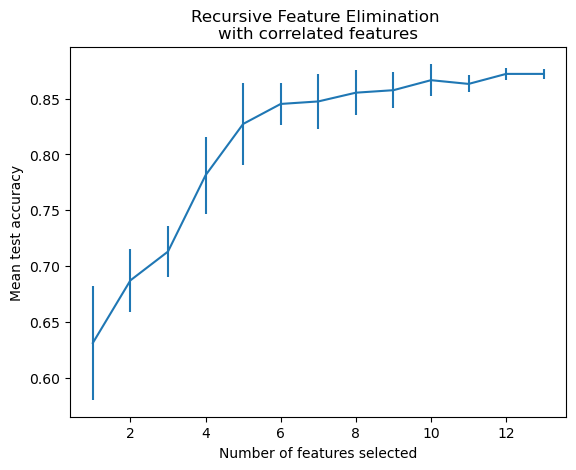

In [17]:
#plotting the accuracy of the classifier across feature numbers
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

Looks Promising! I'm going to through these into a Kbest selector to get the top 5 and then go from there!

In [18]:
#Define new features list
features = list(selected_feat)

# Set up variables
X = Train[features]
y = Train[target]
y = y.values.ravel()

# Select the top 9 best features using mutual information
selector = SelectKBest(mutual_info_classif, k=9)
selector.fit(X, y)

# Get the selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = [features[i] for i in selected_feature_indices]

# Print the list of selected features
print(selected_features)

['AB', 'AF', 'BC', 'CD ', 'CR', 'DI', 'DU', 'FL', 'GL']


In [19]:
#Redfining Features again
features = selected_features
others = ['Id']

#Shaving Data Frames
Train = Train[features + target]
Test = Test[others + features]

#Checking Train with describe
Train.describe()

,AB,AF,BC,CD,CR,DI,DU,FL,GL,Class
count,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000
mean,0.247071,0.224307,0.153923,0.175479,-0.197154,0.189215,0.274276,0.212109,-0.141137,0.500000
std,0.983104,1.013980,0.994388,0.937623,0.991878,1.028245,1.120629,1.064501,0.989465,0.500281
min,-2.274422,-2.758884,-0.853577,-2.702522,-3.348214,-2.064146,-0.875062,-1.063596,-1.089609,0.000000
25%,-0.479894,-0.322884,-0.853577,-0.294213,-0.828404,-0.417804,-0.875062,-1.063596,-1.012425,0.000000
50%,0.295439,0.188413,0.011996,0.165420,-0.124691,0.148592,0.173151,0.579565,-0.858468,0.500000
75%,0.998643,0.737040,1.104641,0.643095,0.386202,0.778997,1.520632,1.168357,1.136380,1.000000
max,2.376152,5.692177,2.012253,4.441437,5.314545,3.512789,1.927812,2.438047,1.136380,1.000000


I'm now going to export the data so I can use it in a collab sheet and get better performance when features tuning my models. I will put code boxes to show how I achived this and import the models as well.

In [20]:
Train.to_csv('Invitro_train.csv', index = False)

Below I'm going to put my tuning code. I just didn't want to put it in the notebook to reduce possible error.

# Setting up X,y
X = Train.iloc[:, : -1]
y = Train['Class']

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reporting util for different optimizers
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers

    optimizer = a sklearn or a skopt optimizer
    X = the training set
    y = our target
    title = a string label for the experiment
    """
    start = time()

    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)

    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_

    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start,
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params
    
    # Setting the scoring function
scoring = make_scorer(f1_score)

# Setting the validation strategy
skf = StratifiedKFold(n_splits=7,
                      shuffle=True,
                      random_state=0)
cv_strategy = list(skf.split(X_train, y_train))

# Setting the basic classifier
xgb_clf = xgb(random_state=0, booster='gbtree', objective='binary:logistic', tree_method='gpu_hist')

# Setting the search space
xgb_search_spaces = {'learning_rate': Real(0.001, 0.3, 'uniform'),
                 'max_depth': Integer(2, 12),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'n_estimators': Integer(50, 10000), #number of trees
                 'gamma': Real(0.0, 1.0, 'uniform')

   }
   
   # Wrapping everything up into the Bayesian optimizer
opt = BayesSearchCV(estimator=xgb_clf,
                    search_spaces=xgb_search_spaces,
                    scoring=scoring,
                    cv=cv_strategy,
                    n_iter=120,                                       # max number of trials
                    n_points=1,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=1,                                         # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,
                    refit=False,
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability
                    
# Running the optimizer
overdone_control = DeltaYStopper(delta=0.0001)                    # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60*60*4)          # We impose a time limit (7 hours)

best_params = report_perf(opt, X_train, y_train,'XGBoost_Classifier',
                          callbacks=[overdone_control, time_limit_control])

I repated the same process for the cat booster

Did my searches and tunings and here is my first 3 models which I will soft ensemble.

In [21]:
#Bring in the models!!!!
xgbc = xgb( learning_rate = 0.3, 
           max_depth = 2,
           n_estimators = 10000, 
           subsample = 0.4469538
)

cat = cb.CatBoostClassifier( border_count = 500,
            colsample_bylevel = 0.6247929386852263,
             iterations =  396,
             l2_leaf_reg = 0.001,
             learning_rate = 0.11183568161972886,
             subsample = 0.4292799728090671,
             verbose = False
)

#tab = TabPFNClassifier(device='cpu', N_ensemble_configurations=4)

In [22]:
#get the data
X = Train.iloc[:,: -1]
y = Train['Class']

X_test = Test[features]

In [23]:
# Create the soft voting ensemble with equal weights
ensemble = VotingClassifier(
    estimators=[('xgbc', xgbc), ('cat', cat)],
    voting='soft',
    weights=[1, 2]
)

# Train the ensemble on your data
ensemble.fit(X, y)

# Make predictions with the ensemble
neg_pred = ensemble.predict_proba(X_test)[:, 0]
pos_pred = ensemble.predict_proba(X_test)[:, 1]
Id = Test['Id']

#Create submission file
# Assuming you have the variables 'neg_pred', 'pos_pred', and 'Id'
data = {'Id': Id, 'class_0': neg_pred, 'class_1': pos_pred}

# Create a DataFrame from the data dictionary
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('submission.csv', index=False)

In [24]:
df.head()

,Id,class_0,class_1
0,00eed32682bb,0.374097,0.625903
1,010ebe33f668,0.374097,0.625903
2,02fa521e1838,0.374097,0.625903
3,040e15f562a2,0.374097,0.625903
4,046e85c7cc7f,0.374097,0.625903
